(week2:hls)=
# Landsat 1: Dowloading Landsat and Sentinel data from NASA

- Download get_landsat_bands.ipynb from the [week2 folder](https://drive.google.com/drive/folders/1-Ja2wVKVIjkZb7Gx_rfc14J_aBYiknuw?usp=sharing)


## Introduction 

This notebook goes over the procedure to locate and download 30 meter resolution
Landsat and Sentinel data using NASA's Harmonized Landsat and Sentinel-2  dataset.
These two satellites have very similar radiometer bands, fly in similar orbits and
have similar resolutions and swath widths.  NASA (Landsat) and the European Space Agency (ESA)
have collaborated on a common dataset that gives corrected surface reflectivity and brightness
temperatures for the two satellites.

## Overview/objectives

In the first few sections, we'll go over how to select a Landsat scene for a particular place and range of dates, and look at the true-color browse image.  This image is available as jpg file without having to
authenticate with an earthdata id.  

Then we'll download a band 5, near-infrared geotif file, where tif stands for "tagged image format".  Here is the [tif wikipedia article](https://en.wikipedia.org/wiki/TIFF). Unlike the jpg format, tif files don't use lossy compression, and contain arbitrary metadata about the image.

Python modules introduced below:

- earthaccess, to send credentials to NASA
- pystac_client, to search the image catalog for satellites, locations and dates
- rioxarray, to read the tif image into memory and store as an xarray.DataArray object
- xarray.DataArray, to access the metadata, make histograms and image plots
- matplotlib.Normalize, to enhance image contrast for plotting specific ranges of reflectivities

We'll go into more detail on xarray and matplotlib/cartopy in future notebooks.

By the end of this notebook you should have a saved tif file of your landsat, band 5 image, and a good idea of what the reflective patterns of the image are.

## Installation

This notebook requires three additions to the a301 environment.  To install them, do

```
conda install earthaccess pystac-client shapely
```

## Authentication

To get NASA to give you your image, you'll need your username and password that you created at [https://urs.earthdata.nasa.gov/](https://urs.earthdata.nasa.gov)

You need to authenticate as described in: [https://earthaccess.readthedocs.io/en/latest/howto/authenticate](https://earthaccess.readthedocs.io/en/latest/howto/authenticate/)

The following steps create a `~/.netrc` file, which  keeps your username and password for future use:

1. open a terminal and activate the a301 environment
2. type `python -i` to get an interactive python session
3. type `import earthaccess`
4. type `auth = earthaccess.login(strategy="interactive", persist=True)` to create an authorization object and write the information into a netrc file for future reference.

Then the next time you need to download or search HLS data you should just be able to do:

In [1]:
import earthaccess
auth = earthaccess.login(strategy="interactive", persist=True)

/Users/andrewbarnett/miniconda3/envs/a448/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Authentication with Earthdata Login failed with:
{"error":"invalid_credentials","error_description":"Invalid user credentials"}


and your credentials will be read in from the netrc file.

You can search the catalog without logging in, but once you ask for data, the earthaccess object will write a new file called "cookies.txt" in the directory  you started jupyterlab in.

##  Doing an image search using pystac_client

STAC is an acronym for "Spatio-temporal asset catalog", which is a standard way of cataloging
GIS resources in the cloud.  A STAC catalog hold metadata, including web addresses, for geotiff
files like those uploaded by the [NASA harmonized landsat-sentinel project](https://www.earthdata.nasa.gov/learn/articles/hls-cloud-efforts) (HLS) to Amazon Web Services.

We get the url for the stac catalog from the "Common Metadata Repository" stored on at [NASA CMR page](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/02_Data_Discovery_CMR-STAC_API.html). The HLS project catalog is called "LPCLOUD"  (for land processes cloud and is available at [https://cmr.earthdata.nasa.gov/stac/LPCLOUD](https://cmr.earthdata.nasa.gov/stac/LPCLOUD).  This is called a "stac endpoint" and will receive
and process requests sent to it by the pystac Client.

We'll also need the [shapely](https://towardsdatascience.com/geospatial-adventures-step-1-shapely-e911e4f86361) library to specify a point on the earth that we want to be included in our search. In addition, we need to specify a date range to search.

In [2]:
import numpy
from pathlib  import Path
import inspect

from matplotlib import pyplot as plt
import numpy as np
from copy import copy

import rioxarray
from pystac_client import Client
from shapely.geometry import Point

Use shapely to create a point object holding the location of UBC.  Also create a datetime object showing the range of days you're interested in searching for images.

In [3]:
hls_lon, hls_lat = -123.120, 49.2827
center_point = Point(hls_lon, hls_lat)
june_2015 = "2015-06-01/2015-06-30"

In [6]:
# connect to the STAC endpoint
cmr_api_url = "https://cmr.earthdata.nasa.gov/stac/LPCLOUD"
client = Client.open(cmr_api_url)

### set up the search

The pystac client object takes the search parameters as the following keywords:

In [7]:
search = client.search(
    collections=["HLSL30.v2.0"],
    intersects=center_point,
    datetime= june_2015
) 
# uncomment below to see gory details
# help(search)

### get the metadata for search items

This search should find 4 scenes -- 2 of which have 4% cloud cover.

In [8]:
items = search.item_collection()
for index, the_scene in enumerate(items):
    print(f"\n\n{index=}\nproperties: {the_scene.properties}")
# items



index=0
properties: {'datetime': '2015-06-05T19:06:24.196Z', 'eo:cloud_cover': 32, 'start_datetime': '2015-06-05T19:06:24.196Z', 'end_datetime': '2015-06-05T19:06:48.079Z'}


index=1
properties: {'datetime': '2015-06-14T19:00:19.142Z', 'eo:cloud_cover': 4, 'start_datetime': '2015-06-14T19:00:19.142Z', 'end_datetime': '2015-06-14T19:00:43.025Z'}


index=2
properties: {'datetime': '2015-06-21T19:06:31.971Z', 'eo:cloud_cover': 34, 'start_datetime': '2015-06-21T19:06:31.971Z', 'end_datetime': '2015-06-21T19:06:55.858Z'}


index=3
properties: {'datetime': '2015-06-30T19:00:26.134Z', 'eo:cloud_cover': 4, 'start_datetime': '2015-06-30T19:00:26.134Z', 'end_datetime': '2015-06-30T19:00:50.021Z'}


### Get the assets for scene 1 (June 14, 2015)

Once we decide on the scene, we can access its assets.  It contains the href (url) for
each of the landsat bands (except Band 8) -- here are their wavelengths:  [Landsat Bands](https://landsat.gsfc.nasa.gov/satellites/landsat-8/landsat-8-bands/)

What happened to band 8? It is in a wavelength range that is only measured by the Sentinel MSI scanner, not the Landsat OLI scanner.  The channel comparisons are given here:
[harmonized channels](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/)

If we had found a Sentinel image instead, we would be missing the thermal channels in Landsat bands 10 and 11.

There are also geotiffs for the 

- Solar Azimuth Angle (SAA) 
- Solar Zenith Angle (SZA)
- Sensor Azimuth Angle (VAA)
- Sensor Zenith Angle (VZA)

and a jpg image file called 'browse' which is a 1000 x 1000 pixel true color image for the scene.  This image is created by mapping bands 2, 3 and 4 to the blue, green and red values in the browse jpg image file file.

The filenames below show that the June 14 scene was taken by Landsat -- Landsat filenames begin with HLS.L30, Sentinel with HLS.S30.  The number 30 is the pixel size in meters:  30 meters high by 30 meters wide

In [9]:
hls_scene = items[1]
hls_scene.assets

{'browse': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSL30.020/HLS.L30.T10UDV.2015165T190019.v2.0/HLS.L30.T10UDV.2015165T190019.v2.0.jpg>,
 'thumbnail_0': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSL30.020/HLS.L30.T10UDV.2015165T190019.v2.0/HLS.L30.T10UDV.2015165T190019.v2.0.jpg>,
 'thumbnail_1': <Asset href=s3://lp-prod-public/HLSL30.020/HLS.L30.T10UDV.2015165T190019.v2.0/HLS.L30.T10UDV.2015165T190019.v2.0.jpg>,
 'B03': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10UDV.2015165T190019.v2.0/HLS.L30.T10UDV.2015165T190019.v2.0.B03.tif>,
 'B01': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10UDV.2015165T190019.v2.0/HLS.L30.T10UDV.2015165T190019.v2.0.B01.tif>,
 'B10': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10UDV.2015165T190019.v2.0/HLS.L30.T10UDV.2015165T190019.v2.0.B10.tif>,
 'B

### Download and display the true-color browse image

You can see the browse image by clicking on the asset href above. We can also use rioxarray to download the browse image from its url.  The browse image is stored as a red green blue jpg file:  [wikipedia page on jpg](https://en.wikipedia.org/wiki/JPEG)

In [10]:
hls_browse = rioxarray.open_rasterio(hls_scene.assets['browse'].href)

/Users/andrewbarnett/miniconda3/envs/a448/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


`hls_browse` is an [xarray DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.htm).  In this case it's a simple 3 dimensional array with shape (3,1000,1000) holding the integer brightness levels (0-255), along with x,y values for each pixel.   These are just values of the pixel centers between 0-1000, since the browse image has no coordinate reference system attached.

In [11]:
type(hls_browse)

xarray.core.dataarray.DataArray

In [12]:
hls_browse

<xarray.DataArray (band: 3, y: 1000, x: 1000)> Size: 3MB
[3000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
  * y            (y) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
    spatial_ref  int64 8B 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

and we can plot it using imshow

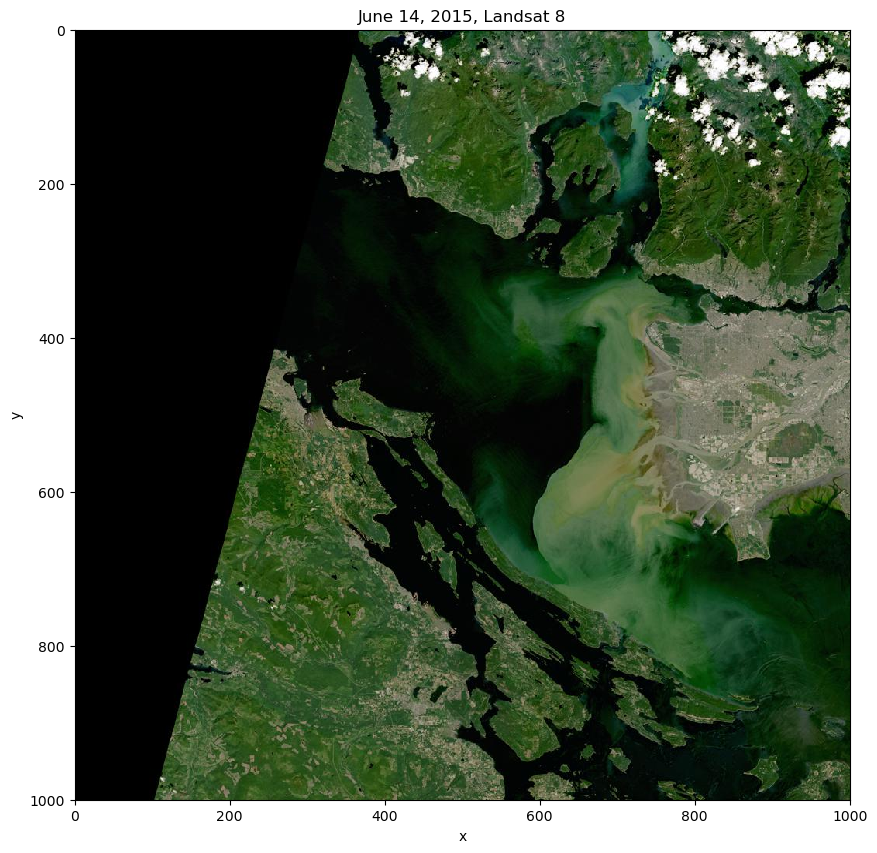

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
hls_browse.plot.imshow(ax=ax, origin = 'upper')
ax.set_title('June 14, 2015, Landsat 8');

## Working with the Band5 geotiff

Landsat Band5 in the near-infrared spans wavelengths between  0.845–0.885 $\mu m$ which are invisible to the human eye. This is a wavelength region where vegetation is very reflective,
because the leaves want to absorb red photons for photosynthesis and reflect slightly longer near-ir photons so they don't get absorbed and 
raise the leaf temperature.  This difference between red (Band4) and near-infrared (Band 5) is called the ["red edge"](https://agrio.app/Red-Edge-reflectance-monitoring-for-early-plant-stress-detection/).  

If you have managed to get your earthdata login into the `~/.netrc` file you should be able to download and save band 5 as shown below:

In [14]:
band_name="B05"
hls_scene.assets[band_name].href

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10UDV.2015165T190019.v2.0/HLS.L30.T10UDV.2015165T190019.v2.0.B05.tif'

### set the cookie file name as an environmental variable

We got the browse image for free, but the actual bands require authorization. The nasa earthdata site will put an encrypted token into the file `cookies.txt` in the current directory ('.') when we ask for band data.

In [15]:
import os
os.environ["GDAL_HTTP_COOKIEFILE"] = "./cookies.txt"
os.environ["GDAL_HTTP_COOKIEJAR"] = "./cookies.txt"

### Read the band 5 raster

The next cell reads in the raster.  By setting `masked=True` we are telling rasterio to look up the `_FillValue` tag in the
geotiff, and replace all pixels that have that value to `np.nan`.

#### Use a local file if available

This step is the one that requires authentication.  NASA counts the number of downloads your account makes in a day, and
will deny access if you exceed a threshold (about 50 downloads).  At the bottom of the notebook in section {ref}`sec:writeout` we write band 5 to disk if the variable `writeit` is set to `True`.  If you want to use that file instead, set the variable `from_disk` to `True`

In [17]:
data_dir = Path().home() / 'repos/a448'
band_name = 5
data_dir.mkdir(exist_ok=True, parents=True)
disk_file = data_dir / f"hls_landsat8_{band_name}.tif"
has_file = disk_file.exists()

from_disk = True
if from_disk:
    if not has_file:
        raise IOError(f"can't find {disk_file}, rerun with from_disk=False and writeit=True") 
    hls_band5 = rioxarray.open_rasterio(disk_file,masked=True)
else:
    # go to NASA
    hls_band5 = rioxarray.open_rasterio(hls_scene.assets['B05'].href,masked=True)

### List all attributes

Unlike the browse image, the actual band 5 tif has metadata.  xarray DataArray objects store metadata as "attributes".  Here are all the attributes we fetched from the tif file.

In [18]:
hls_band5.attrs

{'ACCODE': 'Lasrc; Lasrc',
 'arop_ave_xshift(meters)': '0, 0',
 'arop_ave_yshift(meters)': '0, 0',
 'arop_ncp': '0, 0',
 'arop_rmse(meters)': '0, 0',
 'arop_s2_refimg': 'NONE',
 'cloud_coverage': 4,
 'HLS_PROCESSING_TIME': '2022-03-05T21:45:14Z',
 'HORIZONTAL_CS_NAME': 'UTM, WGS84, UTM ZONE 10; UTM, WGS84, UTM ZONE 10',
 'L1_PROCESSING_TIME': '2020-09-09T04:39:55Z; 2020-09-09T04:39:25Z',
 'LANDSAT_PRODUCT_ID': 'LC08_L1TP_047025_20150614_20200909_02_T1; LC08_L1TP_047026_20150614_20200909_02_T1',
 'LANDSAT_SCENE_ID': 'LC80470252015165LGN02; LC80470262015165LGN02',
 'long_name': 'NIR',
 'MEAN_SUN_AZIMUTH_ANGLE': 144.194636459219,
 'MEAN_SUN_ZENITH_ANGLE': 29.6215707600637,
 'MEAN_VIEW_AZIMUTH_ANGLE': 108.351563730551,
 'MEAN_VIEW_ZENITH_ANGLE': 4.81243847783454,
 'NBAR_SOLAR_ZENITH': 28.5475827060758,
 'NCOLS': 3660,
 'NROWS': 3660,
 'OVR_RESAMPLING_ALG': 'NEAREST',
 'PROCESSING_LEVEL': 'L1TP; L1TP',
 'SENSING_TIME': '2015-06-14T19:00:19.1429430Z; 2015-06-14T19:00:43.0255080Z',
 'SENSOR':

The most important are the coordinate reference system for the image (UTM zone 10N), the coordinates of the upper left corner (not the center) (ULX, ULY), the pixel size (SPATIAL_RESOLUTION), cloud_coverage (4%), and the scale_factor we need to multiply by to get surface refectance from the packed data values.

The DataArray also has three indexes, the first is just the number 1 (only 1 band in the tif), the next 2 are the x,y values of the center of each pixel in UTM 10N coordiates. Note that the  y array gets smaller as the index increases -- the image is scanned from top to bottom.

In [19]:
hls_band5.indexes

Indexes:
    band     Index([1], dtype='int64', name='band')
    x        Index([399975.0, 400005.0, 400035.0, 400065.0, 400095.0, 400125.0, 400155.0,
       400185.0, 400215.0, 400245.0,
       ...
       509475.0, 509505.0, 509535.0, 509565.0, 509595.0, 509625.0, 509655.0,
       509685.0, 509715.0, 509745.0],
      dtype='float64', name='x', length=3660)
    y        Index([5500005.0, 5499975.0, 5499945.0, 5499915.0, 5499885.0, 5499855.0,
       5499825.0, 5499795.0, 5499765.0, 5499735.0,
       ...
       5390505.0, 5390475.0, 5390445.0, 5390415.0, 5390385.0, 5390355.0,
       5390325.0, 5390295.0, 5390265.0, 5390235.0],
      dtype='float64', name='y', length=3660)

### Machine readable crs

The `HORIZONTAL_CS_NAME` attribute is for humans.  To use the image CRS with a program like cartopy we need a more detailed version.  This is supplied by an accessor function added to xarray by rioxarray, with outputs the crs in "well known text (WKT)" format:

In [20]:
hls_band5.rio.crs

CRS.from_wkt('PROJCS["UTM Zone 10, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

### Image  coverage

Here are two ways of finding the image width in km.  The first way gives 109.77 km

In [21]:
((hls_band5.x[-1] - hls_band5.x[0])/1000.)

<xarray.DataArray 'x' ()> Size: 8B
array(109.77)
Coordinates:
    spatial_ref  int64 8B 0

The second gives 109.80 km.  

#### Explain why the two estimates are correct but different.

In [22]:
hls_band5.NCOLS*30./1000.

109.8

### Scaling the image

The cell below removes the useless unit index and converts the image from (1,3660,3660) to (3660,3660), then scales the array.
Note that by doing arithemetic on the image, we lose all the metadata, but we keep the indexes.

In [23]:
hls_raster = hls_band5.squeeze()
hls_raster = hls_raster*hls_band5.scale_factor
hls_raster.attrs, hls_raster.indexes

({},
 Indexes:
     x        Index([399975.0, 400005.0, 400035.0, 400065.0, 400095.0, 400125.0, 400155.0,
        400185.0, 400215.0, 400245.0,
        ...
        509475.0, 509505.0, 509535.0, 509565.0, 509595.0, 509625.0, 509655.0,
        509685.0, 509715.0, 509745.0],
       dtype='float64', name='x', length=3660)
     y        Index([5500005.0, 5499975.0, 5499945.0, 5499915.0, 5499885.0, 5499855.0,
        5499825.0, 5499795.0, 5499765.0, 5499735.0,
        ...
        5390505.0, 5390475.0, 5390445.0, 5390415.0, 5390385.0, 5390355.0,
        5390325.0, 5390295.0, 5390265.0, 5390235.0],
       dtype='float64', name='y', length=3660))

In [24]:
hls_raster.attrs = hls_band5.attrs
hls_raster.x[0]

<xarray.DataArray 'x' ()> Size: 8B
array(399975.)
Coordinates:
    band         int64 8B 1
    x            float64 8B 4e+05
    spatial_ref  int64 8B 0

### Histogram the raster

Make sure the scaled band5 reflectance is in the range 0-1

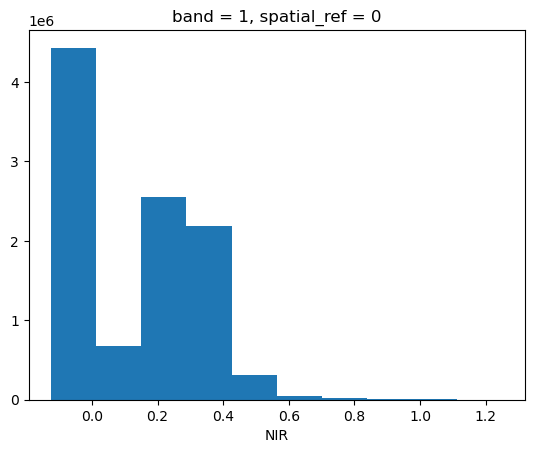

In [25]:
hls_raster.plot.hist();

### Plot it using a grey palette

We can use the Normalize object to adjust the maximum range we want to assign colors to.  In this case,
we don't want to waste colors on the very few pixels with reflectances higher than 0.8.  We'll use a grey scale colormap.  Note that the DataArray object
knows how to use the x and y indexes to label the axis tick marks in map coordinates.

In [26]:
pal = copy(plt.get_cmap("Greys_r"))
pal.set_bad("0.75")  # color 75% grey np.nan cells
pal.set_over("w")  # color cells > vmax red
pal.set_under("k")  # color cells < vmin black
vmin = 0.0  #anything under this is colored black
vmax = 0.8  #anything over this is colored white
from matplotlib.colors import Normalize
the_norm = Normalize(vmin=vmin, vmax=vmax, clip=False)

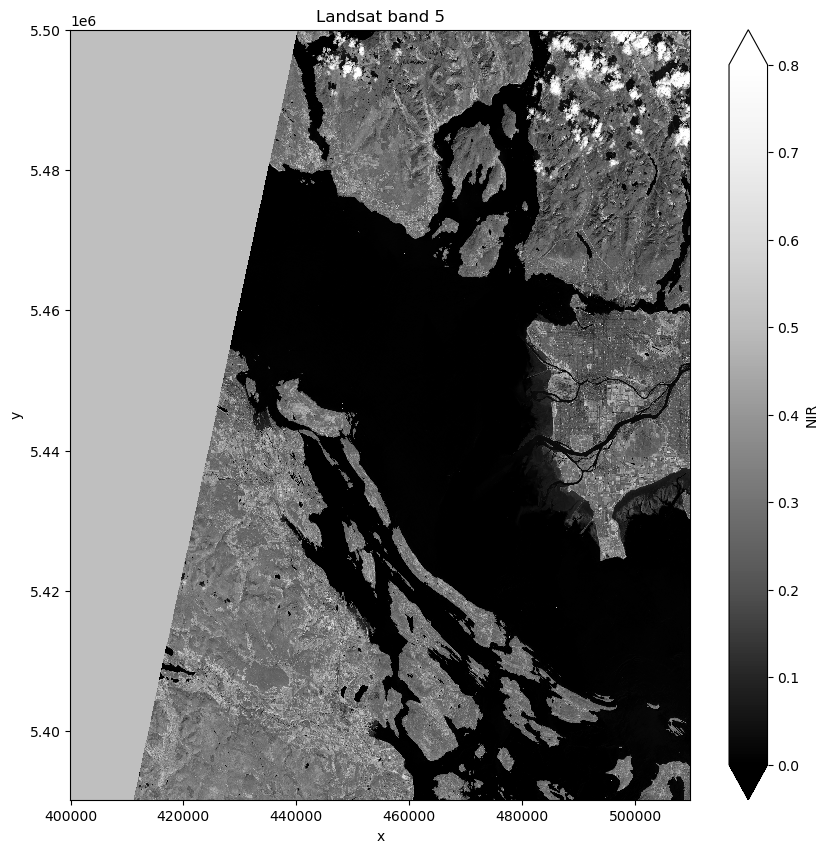

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
hls_raster.plot(ax=ax, cmap=pal, norm = the_norm)
ax.set_title(f"Landsat band {band_name}");

(sec:writeout)=
### Write out the raster as a geotiff

Save the original tif to disk so you don't need to go back to NASA

In [28]:
writeit=True
if writeit:
    hls_band5.rio.to_raster(disk_file)
    #check if write worked
    hls_band5 = rioxarray.open_rasterio(disk_file,masked=True)
    print(f"checking read, here is the crs: {hls_band5.rio.crs}")

checking read, here is the crs: PROJCS["UTM Zone 10, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


## What's next

Now that we can get landsat and sentinel scenes, we need to be able to 
subset to a particular part of the image, apply the cloud mask to remove cloudy
pixels and use channel ratios to infer surface properties.  That's the topic for the
next few notebooks.


### For Monday's class
For Monday, copy this notebook and edit it to download and save a new tif containing band 4 (red) for your location.